In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

train_dir = r'C:\Users\doubl\Downloads\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'
valid_dir = r'C:\Users\doubl\Downloads\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid'
test_dir = r'C:\Users\doubl\Downloads\test\test'  

class_names = sorted(os.listdir(train_dir))
print("Class Names:", class_names)


train_dataset = image_dataset_from_directory(train_dir, image_size=(224, 224), batch_size=32, label_mode='categorical')
valid_dataset = image_dataset_from_directory(valid_dir, image_size=(224, 224), batch_size=32, label_mode='categorical')

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomat

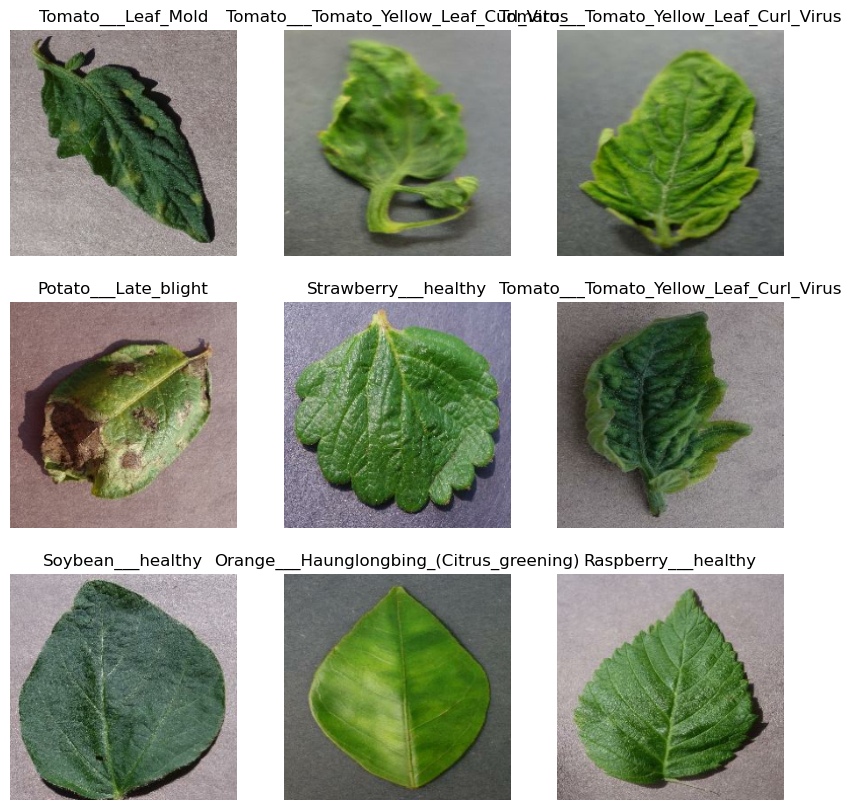

In [2]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i])  
        plt.title(class_names[class_index]) 
        plt.axis("off")
plt.show()


In [5]:
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = False
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Epoch 1/4
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 5281s 2s/step - accuracy: 0.7421 - loss: 0.8970 - val_accuracy: 0.9393 - val_loss: 0.1827
Epoch 2/4
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 4471s 2s/step - accuracy: 0.8929 - loss: 0.3265 - val_accuracy: 0.9570 - val_loss: 0.1277
Epoch 3/4
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 4239s 2s/step - accuracy: 0.9066 - loss: 0.2823 - val_accuracy: 0.9590 - val_loss: 0.1233
Epoch 4/4
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 4401s 2s/step - accuracy: 0.9157 - loss: 0.2625 - val_accuracy: 0.9647 - val_loss: 0.1082


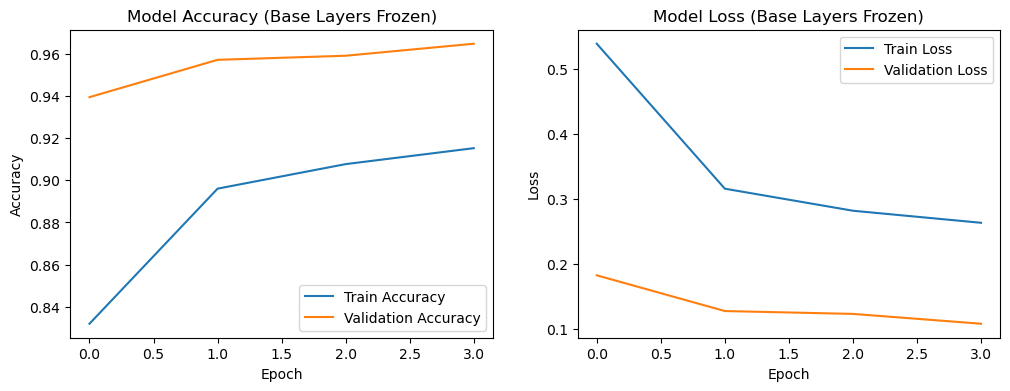

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=4,
                    callbacks=[early_stop])
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Base Layers Frozen)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Base Layers Frozen)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


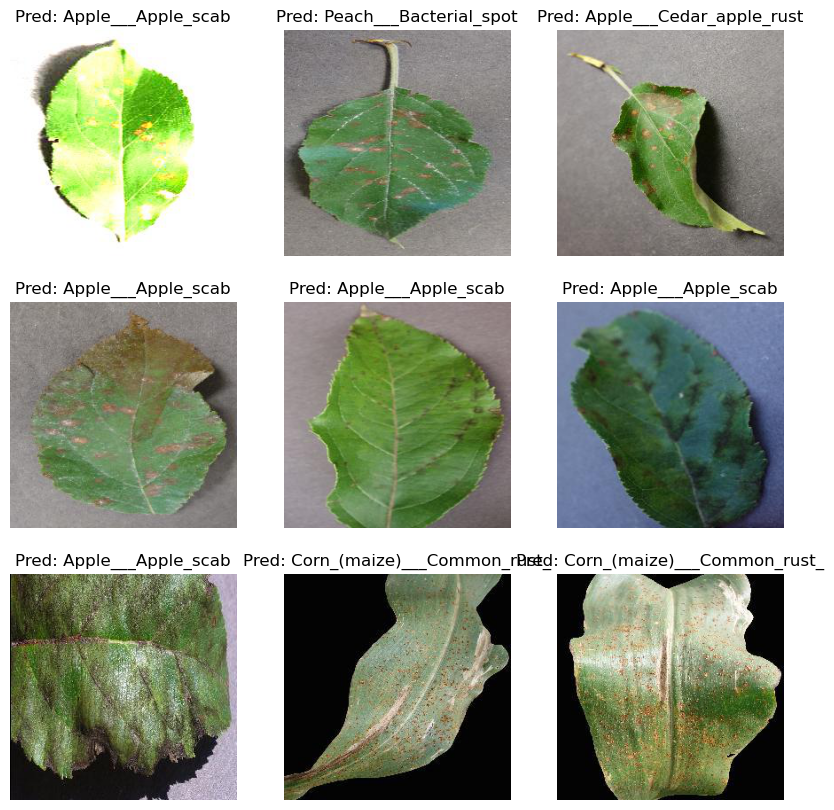

In [8]:
# Load and preprocess test images
test_images = []
test_image_paths = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]

for img_path in test_image_paths:
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess input for ResNet50
    test_images.append(img_array)

test_images = np.vstack(test_images)  # Stack into a single array

# Make predictions
predictions = model.predict(test_images)

# Visualize test images with predicted class names
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = tf.keras.preprocessing.image.load_img(test_image_paths[i])  # Load test image
    plt.imshow(img)
    predicted_class = class_names[np.argmax(predictions[i])]  # Map prediction to class name
    plt.title(f"Pred: {predicted_class}")
    plt.axis("off")
plt.show()


550/550 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.9633 - loss: 0.1085
Validation Accuracy: 0.9647
Validation Loss: 0.1082
550/550 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.04      0.05      0.05       504
                                 Apple___Black_rot       0.03      0.03      0.03       497
                          Apple___Cedar_apple_rust       0.02      0.02      0.02       440
                                   Apple___healthy       0.04      0.04      0.04       502
                               Blueberry___healthy       0.03      0.03      0.03       454
          Cherry_(including_sour)___Powdery_mildew       0.01      0.01      0.01       421
                 Cherry_(including_sour)___healthy       0.04      0.04      0.04       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.04      0.04      0.04       410
 

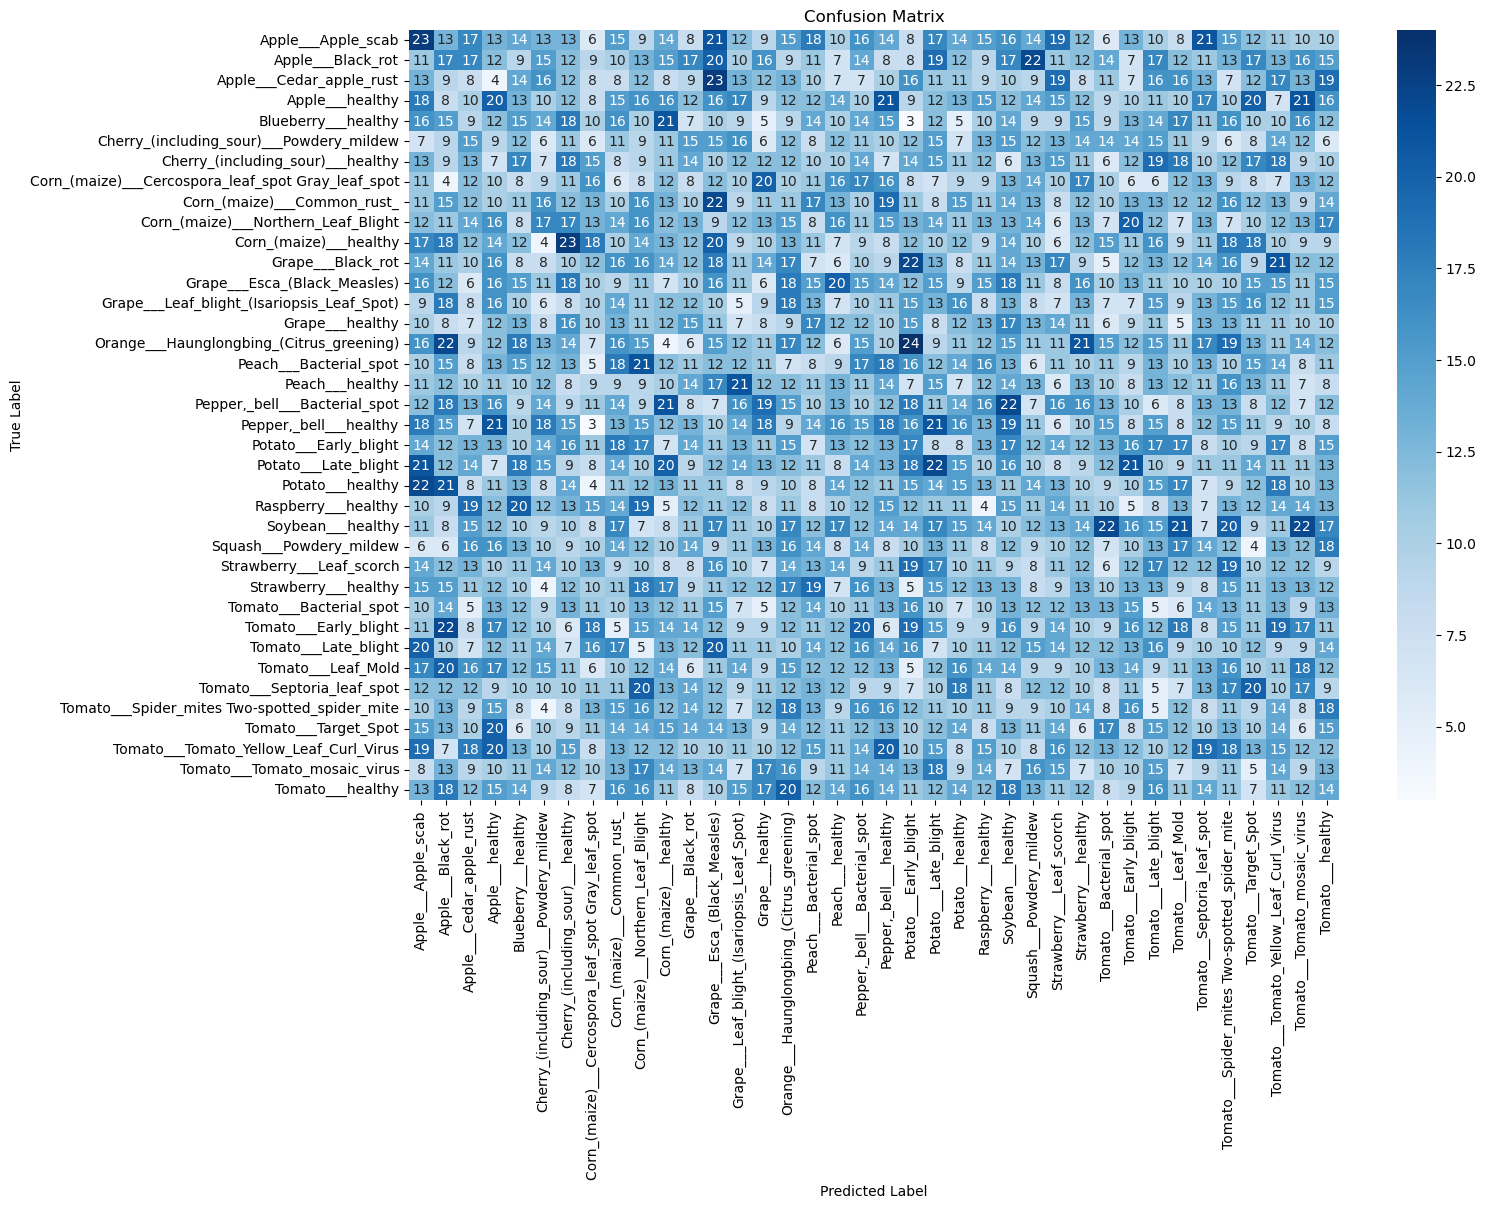

In [9]:
# Evaluate model on validation dataset
val_loss, val_acc = model.evaluate(valid_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Generate classification report and confusion matrix with class names
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)
y_pred = model.predict(valid_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Classification report with class names
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# Confusion matrix with class names
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [ ]:
import gradio as gr
from PIL import Image

# Updated prediction function
def predict_disease(image):
    try:
        # Resize the input image to 224x224
        img = image.resize((224, 224))
        
        # Convert the image to a NumPy array and preprocess
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess input for ResNet50
        
        # Get predictions
        prediction = model.predict(img_array)
        predicted_class = class_names[np.argmax(prediction)]  # Map index to class name

        return predicted_class  # Return only the class name
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio interface
interface = gr.Interface(
    fn=predict_disease,
    inputs=gr.Image(type="pil"),  # Input image as a PIL object
    outputs="text",  # Output only the class name
    title="Plant Disease Detection",
    description="Upload an image of a plant leaf to detect the disease.",
    examples=[
        os.path.join(test_dir, img) for img in os.listdir(test_dir)[:5]  # Include a few test images as examples
    ],
)

# Launch the interface
interface.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Using existing dataset file at: .gradio\flagged\dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
